# CheXpert – CBM Metadata (X → C → Y)

This notebook uses the **CheXpert (Kaggle – CheXpert-v1.0-small)** dataset and follows the
**Concept Bottleneck Model (CBM)** structure:

---

## CBM formulation

We define the learning problem as:

**X → C → Y**

- **X (input)**: chest X-ray image
- **C (concepts)**: radiological findings annotated by experts
- **Y (target task)**: clinical label prediction (can be single disease or multi-label diagnosis)

---

## X – Input

**X = image**

Each sample contains one chest X-ray image (frontal or lateral view).

Image path is provided in the column:

- `Path`

---

## Metadata (non-concept attributes)

The following columns are considered as *image-level metadata* and are **not medical concepts**:

- `Sex`
- `Age`
- `Frontal/Lateral`
- `AP/PA`

These variables can be used later for:
- bias analysis,
- stratified evaluation,
- or as optional auxiliary inputs.

They are not part of the medical concept bottleneck.

---

## C – Concepts (radiological findings)

We define the concept vector **C** as the following 14 medical findings:

| Index | Concept name |
|------:|-------------|
| 0 | No Finding |
| 1 | Enlarged Cardiomediastinum |
| 2 | Cardiomegaly |
| 3 | Lung Opacity |
| 4 | Lung Lesion |
| 5 | Edema |
| 6 | Consolidation |
| 7 | Pneumonia |
| 8 | Atelectasis |
| 9 | Pneumothorax |
| 10 | Pleural Effusion |
| 11 | Pleural Other |
| 12 | Fracture |
| 13 | Support Devices |

Each concept is annotated with one of the following values:

- **1**  → positive (concept present)
- **0**  → negative (concept absent)
- **-1** → uncertain
- **NaN** → missing

In this notebook, the concept prediction task is therefore a **multi-label concept classification** problem.

---

## Concept structure

The CheXpert concepts are **flat binary medical findings**.

They do NOT form predefined categories in the dataset.
However, for interpretability and analysis, they can be grouped semantically as:

### Cardiac
- Enlarged Cardiomediastinum
- Cardiomegaly

### Pulmonary / Parenchymal
- Lung Opacity
- Lung Lesion
- Consolidation
- Pneumonia
- Atelectasis
- Edema

### Pleural
- Pleural Effusion
- Pleural Other
- Pneumothorax

### Musculoskeletal
- Fracture

### Devices / Technical
- Support Devices

### Global
- No Finding

These groups are only used for analysis and interpretation, not for training.

---

## Y – Target task

For a standard CBM setup on CheXpert:

- **Y is a diagnosis target derived from the same medical findings.**

Typical choices for Y:

- one specific disease (e.g. Pneumonia detection), or
- a multi-label disease prediction task.

In the first stage of CBM used in this project, we focus on:

**X → C**

and train a concept encoder to predict all 14 concepts.

The second stage will model:

**C → Y**

to study how concepts affect diagnostic predictions and interpretability.

---

## CBM-style metadata for CheXpert ( Example Pleural)

```python
metadata = {
    "task_id": "Task1_Pleural",
    "task_name": "Pleural_detection",
    "base_concepts": [
        "Pneumothorax",
        "Pleural Effusion",
        "Pleural Other",
    ],
    "target_concept": "Pleural_detection",
    "expected_pattern": "Pneumothorax ∨ Pleural Effusion ∨ Pleural Other",
    "description": "Chest X-ray image → pleural-related radiological concepts → pleural pathology detection",
    "concept_indices": {
        "No Finding": 0,
        "Enlarged Cardiomediastinum": 1,
        "Cardiomegaly": 2,
        "Lung Opacity": 3,
        "Lung Lesion": 4,
        "Edema": 5,
        "Consolidation": 6,
        "Pneumonia": 7,
        "Atelectasis": 8,
        "Pneumothorax": 9,
        "Pleural Effusion": 10,
        "Pleural Other": 11,
        "Fracture": 12,
        "Support Devices": 13
    }
}


## Inspect labels and metadata :

In [3]:
# Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
# Dataset path

DATASET_ROOT = "./data/chexpert/CheXpert-v1.0-small"

TRAIN_CSV = os.path.join(DATASET_ROOT, "train.csv")
VALID_CSV = os.path.join(DATASET_ROOT, "valid.csv")

print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Valid CSV exists:", os.path.exists(VALID_CSV))

Train CSV exists: True
Valid CSV exists: True


In [5]:
# Load CSV files

train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))

train_df.head()

Train size: 223414
Valid size: 234


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
# List all columns
print(train_df.columns.tolist())


['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [7]:
# Separate metadata vs label columns

METADATA_COLUMNS = [
    "Path",
    "Sex",
    "Age",
    "Frontal/Lateral",
    "AP/PA"
]

print("Metadata columns:")
for c in METADATA_COLUMNS:
    print("-", c)


Metadata columns:
- Path
- Sex
- Age
- Frontal/Lateral
- AP/PA


We define the concept set C as the clinical observations provided by CheXpert.

These concepts are:

- No Finding
- Enlarged Cardiomediastinum
- Cardiomegaly
- Lung Opacity
- Lung Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural Effusion
- Pleural Other
- Fracture
- Support Devices

These are human-interpretable and clinically meaningful concepts.
They form the bottleneck layer in the CBM model.


In [8]:
# Define clinical label columns (visual concepts)

LABEL_COLUMNS = [c for c in train_df.columns if c not in METADATA_COLUMNS]

print("Number of label columns:", len(LABEL_COLUMNS))
print(LABEL_COLUMNS)


Number of label columns: 14
['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [9]:

def label_statistics(df, label):
    return {
        "positive": (df[label] == 1).sum(),
        "negative": (df[label] == 0).sum(),
        "uncertain": (df[label] == -1).sum(),
        "missing": df[label].isna().sum()
    }

stats = pd.DataFrame({
    label: label_statistics(train_df, label)
    for label in LABEL_COLUMNS
}).T

stats


,positive,negative,uncertain,missing
No Finding,22381,0,0,201033
Enlarged Cardiomediastinum,10798,21638,12403,178575
Cardiomegaly,27000,11116,8087,177211
Lung Opacity,105581,6599,5598,105636
Lung Lesion,9186,1270,1488,211470
Edema,52246,20726,12984,137458
Consolidation,14783,28097,27742,152792
Pneumonia,6039,2799,18770,195806
Atelectasis,33376,1328,33739,154971
Pneumothorax,19448,56341,3145,144480


In [10]:
# Inspect value distribution for one concept

def inspect_label_distribution(df, label):
    values = df[label].value_counts(dropna=False)
    return values

inspect_label_distribution(train_df, LABEL_COLUMNS[0])


No Finding
NaN    201033
1.0     22381
Name: count, dtype: int64

Basic statistics per concept

We count how many:
- positive (1)
- negative (0)
- uncertain (-1)
- missing (NaN)

for each concept.

In [11]:
## Show distributions for all concepts

summary = {}

for label in LABEL_COLUMNS:
    counts = train_df[label].value_counts(dropna=False)
    summary[label] = counts

summary_df = pd.DataFrame(summary).fillna(0).astype(int)
summary_df


,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
-1.0,0,12403,8087,5598,1488,12984,27742,18770,33739,3145,11628,2653,642,1079
0.0,0,21638,11116,6599,1270,20726,28097,2799,1328,56341,35396,316,2512,6137
1.0,22381,10798,27000,105581,9186,52246,14783,6039,33376,19448,86187,3523,9040,116001
NaN,201033,178575,177211,105636,211470,137458,152792,195806,154971,144480,90203,216922,211220,100197


CheXpert labels take the following values:

-  1  → positive finding
-  0  → negative finding
- -1  → uncertain finding
- NaN → not mentioned in the report

These labels are extracted automatically from radiology reports
using a rule-based NLP system (not manual image annotation).


In [12]:
## Check missing rate for each concept (NaN)

missing_rates = {}

for c in LABEL_COLUMNS:
    missing_rates[c] = train_df[c].isna().mean()

pd.Series(missing_rates).sort_values(ascending=False)



Pleural Other                 0.970942
Lung Lesion                   0.946539
Fracture                      0.945420
No Finding                    0.899823
Pneumonia                     0.876427
Enlarged Cardiomediastinum    0.799301
Cardiomegaly                  0.793196
Atelectasis                   0.693649
Consolidation                 0.683896
Pneumothorax                  0.646692
Edema                         0.615261
Lung Opacity                  0.472826
Support Devices               0.448481
Pleural Effusion              0.403748
dtype: float64

Check missing and uncertainty rate


Missing rate

- how often the concept is not mentioned at all (NaN)

Uncertainty rate

- how often the concept is mentioned but uncertain (-1)

In [13]:
## Check uncertainty rate (-1) for each concept 

uncertainty_rates = {}

for c in LABEL_COLUMNS:
    uncertainty_rates[c] = (train_df[c] == -1).mean()

pd.Series(uncertainty_rates).sort_values(ascending=False)

Atelectasis                   0.151016
Consolidation                 0.124173
Pneumonia                     0.084014
Edema                         0.058116
Enlarged Cardiomediastinum    0.055516
Pleural Effusion              0.052047
Cardiomegaly                  0.036197
Lung Opacity                  0.025057
Pneumothorax                  0.014077
Pleural Other                 0.011875
Lung Lesion                   0.006660
Support Devices               0.004830
Fracture                      0.002874
No Finding                    0.000000
dtype: float64

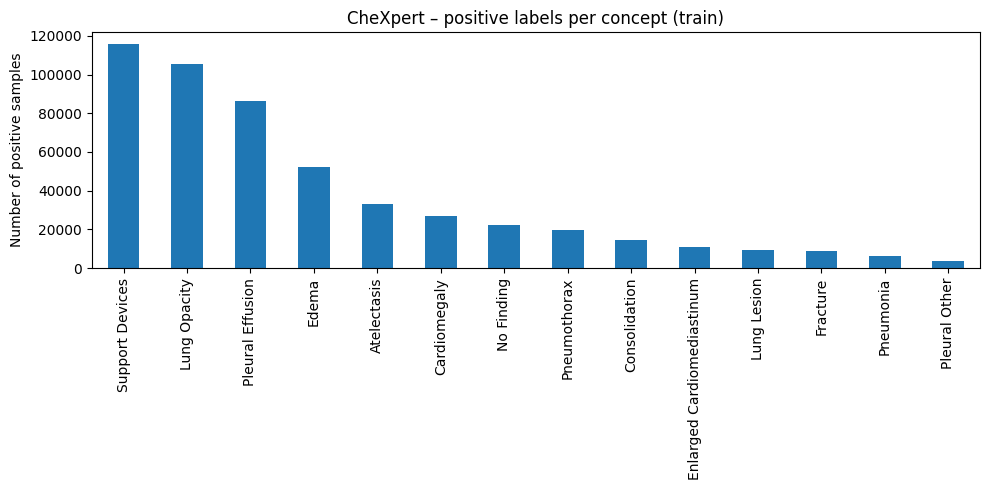

In [14]:
##  Visualization of positive samples per concept

pos_counts = stats["positive"]

plt.figure(figsize=(10,5))
pos_counts.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Number of positive samples")
plt.title("CheXpert – positive labels per concept (train)")
plt.tight_layout()
plt.show()
